# Real-World Data Demonstration

### Team Epsilon-Greedy Quants
#### Michael Lee, Nikat Patel, Jose Antonio Alatorre Sanchez

This notebook is a demonstration of how to load real-world data into our model and perform Policy-Gradient Methods such as REINFORCE, REINFORCE with Baseline, Actor-Critic, and Actor-Critic with Eligibility Traces.

In [1]:
from environments.e_greedy import DeepTradingEnvironment, LinearAgent

import datetime
import numpy as np
import pandas as pd
import os
from utils import train_val_test
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import quantstats as qs
qs.extend_pandas()

In [2]:
root = os.getcwd()
data_env = root+"/data_env/"

# Utility Functions

In [3]:
def _retrieve_asset_dict():
    # obtain close prices from parquet files of ETF price history
    root = os.getcwd()
    data_env = root+"/data_env/"
    files = [_ for _ in os.listdir(data_env) if "parquet" in _]
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
    else:
        main_index=main_index.join(value.index,how="inner")
        
    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()
    
    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)
        
    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce')
    return portfolio_df

In [4]:
def plot_backtest(linear_agent_train, env_test, test_input, model):
    ## Create plot of backtest returns
    if not "backtest" in locals():
        backtest=None
    backtest=linear_agent_train.backtest_policy(epoch=1,backtest=backtest, env_test=env_test, test_input=test_input)
    plt.figure(figsize=(8,4))
    plt.plot(backtest,color="blue")
    plt.gcf().autofmt_xdate()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel("Date", fontsize = 10)
    plt.ylabel("Backtest", fontsize = 10)
    plt.title("Backtest on Test Data: "+ model,fontsize = 16)
    plt.savefig(root+'/temp_persisted_data/backtest_'+model+'.png')
    plt.show()
    return backtest

# Reviewing Real-World Data

In [5]:
# read a sample ETF
pd.read_parquet(data_env+'EEMV.parquet').head()

,open,high,low,close,volume
index,,,,,
2017-01-03 05:00:00+00:00,45.08700,45.26144,44.93093,45.07782,926496
2017-01-04 05:00:00+00:00,45.50014,45.63785,45.50014,45.54604,973660
2017-01-05 05:00:00+00:00,45.92245,46.16116,45.92245,46.14280,646347
2017-01-06 05:00:00+00:00,45.94082,45.94082,45.74802,45.81229,563348
2017-01-09 05:00:00+00:00,45.71130,45.79393,45.65621,45.71130,615522


In [6]:
# create a portfolio
assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)

In [7]:
# create a train dataset and de-mean the time series

portfolio_df_train = portfolio_df[portfolio_df.index <= '2020-04-01']
portfolio_df_train.sub(portfolio_df_train.mean())

portfolio_df_train.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2017-01-03 05:00:00+00:00,45.07782,54.69828,72.54646,65.02215,67.17120,42.06556,64.23762
2017-01-04 05:00:00+00:00,45.54604,55.25160,72.97556,65.38650,67.97419,42.26039,64.91695
2017-01-05 05:00:00+00:00,46.14280,55.90309,73.21394,65.32110,67.81546,42.30678,64.56370
2017-01-06 05:00:00+00:00,45.81229,55.76030,73.63351,65.54532,68.04888,42.36245,64.50029
2017-01-09 05:00:00+00:00,45.71130,55.76923,73.60490,65.21833,67.72208,42.15833,64.26479


In [8]:
# create a test dataset consisting of 6 months of data and de-mean the time series

portfolio_df_test = portfolio_df[portfolio_df.index >= '2020-04-16']
portfolio_df_test = portfolio_df_test[portfolio_df_test.index <= '2020-11-16']
portfolio_df_test.sub(portfolio_df_test.mean())

portfolio_df_test.head()

,EEMV,EFAV,MTUM,QUAL,SIZE,USMV,VLUE
index,,,,,,,
2020-04-16 04:00:00+00:00,48.20911,62.50506,116.0638,86.18110,75.67554,57.85078,65.36022
2020-04-17 04:00:00+00:00,48.88692,63.45106,117.9653,88.67091,78.40196,59.53394,67.65253
2020-04-20 04:00:00+00:00,48.48617,62.79575,116.7009,87.05402,77.06354,58.23692,66.08150
2020-04-21 04:00:00+00:00,47.54613,61.94337,112.3304,84.47494,74.79317,56.78149,63.82873
2020-04-22 04:00:00+00:00,48.56533,62.75141,115.3270,86.41917,76.31997,57.81118,65.00452


# Set Up Environment

In [9]:
# parameters related to the transformation of data, this parameters govern an step before the algorithm
out_reward_window=datetime.timedelta(days=7)

meta_parameters = {"in_bars_count": 14,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window",
                   "risk_aversion":10,
                   "include_previous_weights":False}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001}

print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)

# create an environment and build features based on Real-World Dataset located in the "data_env" folder 
env = DeepTradingEnvironment.build_environment_from_dirs_and_transform(meta_parameters, objective_parameters,data_hash="real_data", data_dir="data_env")

number_of_assets = env.number_of_assets

===Meta Parameters===
{'in_bars_count': 14, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window', 'risk_aversion': 10, 'include_previous_weights': False}
===Objective Parameters===
{'percent_commission': 0.001}


#### Split Features and Forward Returns into Training and Test sets

In [10]:

features = pd.read_parquet("temp_persisted_data/only_features_real_data")

features_train = features[features.index <= '2020-04-01']
features_test = features[features.index >= '2020-04-16']
features_test = features_test[features_test.index <= '2020-11-16']

features_test.head()

,EEMV.parquet_log_returns,EFAV.parquet_log_returns,MTUM.parquet_log_returns,QUAL.parquet_log_returns,SIZE.parquet_log_returns,USMV.parquet_log_returns,VLUE.parquet_log_returns,EEMV.parquet_log_returns_lag_0,EFAV.parquet_log_returns_lag_0,MTUM.parquet_log_returns_lag_0,...,SIZE.parquet_log_returns_lag_12,USMV.parquet_log_returns_lag_12,VLUE.parquet_log_returns_lag_12,EEMV.parquet_log_returns_lag_13,EFAV.parquet_log_returns_lag_13,MTUM.parquet_log_returns_lag_13,QUAL.parquet_log_returns_lag_13,SIZE.parquet_log_returns_lag_13,USMV.parquet_log_returns_lag_13,VLUE.parquet_log_returns_lag_13
index,,,,,,,,,,,,,,,,,,,,,
2020-04-16 04:00:00+00:00,-0.004097,0.003949,0.015996,0.002074,0.000393,0.005147,-0.002868,-0.015416,-0.020832,-0.012903,...,-0.030387,-0.021026,-0.038587,0.035069,0.048233,0.063901,0.054616,0.058099,0.067378,0.062540
2020-04-17 04:00:00+00:00,0.013962,0.015021,0.016250,0.028481,0.035394,0.028680,0.034471,-0.004097,0.003949,0.015996,...,0.024547,0.031556,0.027913,-0.044196,-0.022524,-0.019721,-0.031580,-0.030387,-0.021026,-0.038587
2020-04-20 04:00:00+00:00,-0.008231,-0.010382,-0.010776,-0.018403,-0.017219,-0.022027,-0.023496,0.013962,0.015021,0.016250,...,-0.018927,-0.024869,-0.020425,0.012582,0.022205,0.031352,0.036687,0.024547,0.031556,0.027913
2020-04-21 04:00:00+00:00,-0.019578,-0.013667,-0.038170,-0.030074,-0.029904,-0.025309,-0.034685,-0.008231,-0.010382,-0.010776,...,-0.051603,-0.039080,-0.057158,0.011360,-0.012651,-0.030977,-0.017249,-0.018927,-0.024869,-0.020425
2020-04-22 04:00:00+00:00,0.021210,0.012960,0.026327,0.022755,0.020208,0.017972,0.018253,-0.019578,-0.013667,-0.038170,...,0.013771,0.022088,0.013687,-0.038454,-0.037939,-0.049969,-0.042603,-0.051603,-0.039080,-0.057158


In [11]:
forward_return_dates = pd.read_parquet("temp_persisted_data/forward_return_dates_real_data")

forward_return_dates_train = forward_return_dates[forward_return_dates.index <= '2020-04-01']
forward_return_dates_test = forward_return_dates[forward_return_dates.index > '2020-04-16']
forward_return_dates_test = forward_return_dates_test[forward_return_dates_test.index <= '2020-11-16']

forward_return_dates_test.head()

,"forward_return_7_days,_0:00:00"
index,
2020-04-16 04:00:00+00:00,2020-04-23 04:00:00+00:00
2020-04-17 04:00:00+00:00,2020-04-24 04:00:00+00:00
2020-04-20 04:00:00+00:00,2020-04-27 04:00:00+00:00
2020-04-21 04:00:00+00:00,2020-04-28 04:00:00+00:00
2020-04-22 04:00:00+00:00,2020-04-29 04:00:00+00:00


In [12]:
forward_returns = pd.read_parquet("temp_persisted_data/only_forward_returns_real_data")

forward_returns_train = forward_returns[forward_returns.index <= '2020-04-01']
forward_returns_test = forward_returns[forward_returns.index >= '2020-04-16']
forward_returns_test = forward_returns_test[forward_returns_test.index <= '2020-11-16']

forward_returns_test.head()

,"EEMV.parquet_forward_return_7_days,_0:00:00","EFAV.parquet_forward_return_7_days,_0:00:00","MTUM.parquet_forward_return_7_days,_0:00:00","QUAL.parquet_forward_return_7_days,_0:00:00","SIZE.parquet_forward_return_7_days,_0:00:00","USMV.parquet_forward_return_7_days,_0:00:00","VLUE.parquet_forward_return_7_days,_0:00:00"
index,,,,,,,
2020-04-16 04:00:00+00:00,0.008621,-0.002207,-0.009007,0.001727,0.010481,-0.008215,-0.002268
2020-04-17 04:00:00+00:00,-0.004554,-0.007455,-0.010802,-0.010963,-0.011002,-0.027441,-0.021908
2020-04-20 04:00:00+00:00,0.022653,0.013103,0.012626,0.024727,0.032163,0.010031,0.026166
2020-04-21 04:00:00+00:00,0.044121,0.030385,0.038908,0.056130,0.069989,0.035745,0.074304
2020-04-22 04:00:00+00:00,0.042176,0.029758,0.036516,0.059458,0.078072,0.027059,0.094695


# Run Policy-Gradient Method Algorithms on Real-World Data

In [13]:
max_iter = 10000
model_run = "demeaned_return_reward_variance_risk_10_"
sample_observations = 4

### REINFORCE

 20%|███████████████▍                                                             | 2000/10000 [00:26<01:46, 75.01it/s]

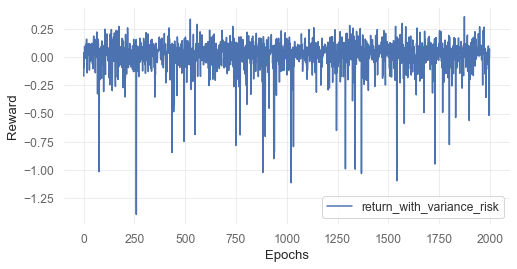

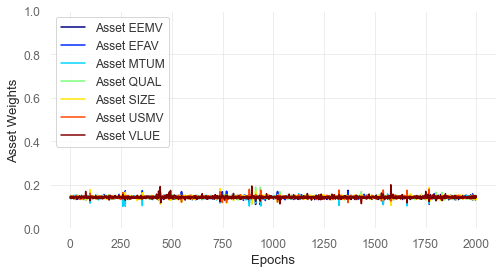

 40%|██████████████████████████████▊                                              | 3997/10000 [00:54<01:15, 79.30it/s]

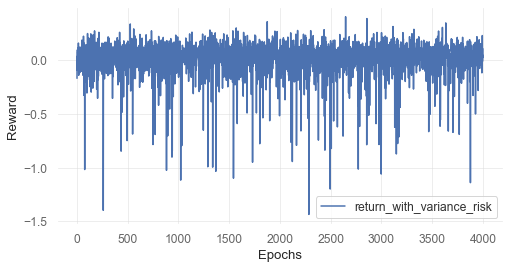

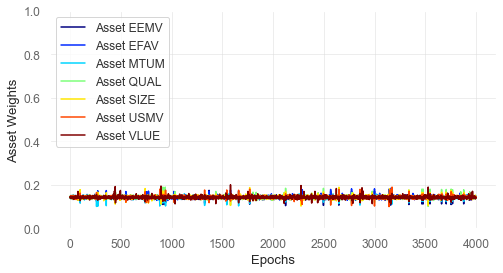

 60%|██████████████████████████████████████████████▏                              | 5993/10000 [01:22<00:58, 67.94it/s]

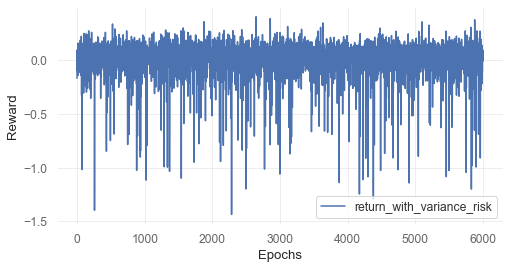

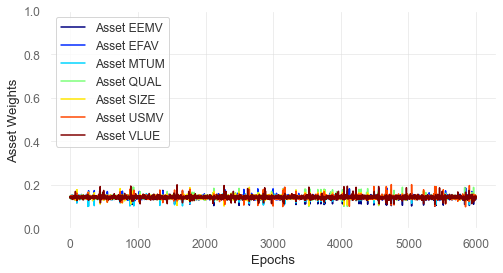

 80%|█████████████████████████████████████████████████████████████▌               | 7999/10000 [01:52<00:30, 65.04it/s]

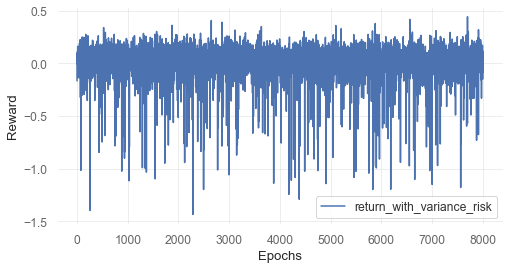

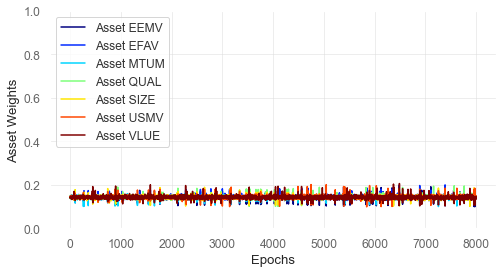

100%|████████████████████████████████████████████████████████████████████████████▉| 9997/10000 [02:28<00:00, 45.01it/s]

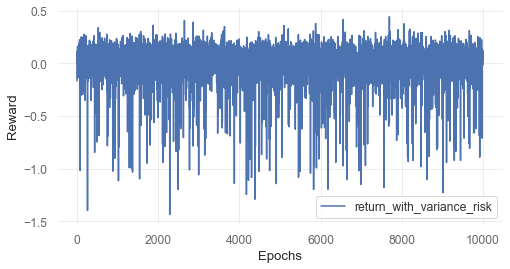

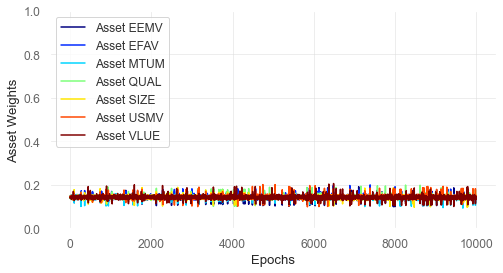

[]

In [14]:
# create environment and run REINFORCE

env_reinforce_train=DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce = LinearAgent(environment=env_reinforce_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce.REINFORCE_fit(max_iterations=max_iter, add_baseline=False, verbose=True)

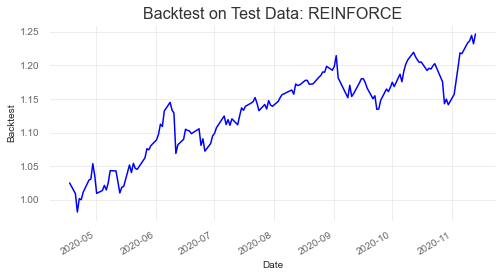

In [15]:
# perform backtest 
backtest_reinforce = plot_backtest(linear_agent_reinforce, env_reinforce_test, portfolio_df_test, model="REINFORCE")
backtest_reinforce.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce.csv')

### REINFORCE with Baseline


pre-sampling indices: 100%|█████████████████████████████████████████████████████████| 528/528 [00:01<00:00, 342.72it/s]

  2%|█▉                                                                            | 247/10000 [00:05<04:13, 38.40it/s]


  6%|████▌                                                                         | 581/10000 [00:13<03:18, 47.51it/s]


  9%|██████▉                                                                       | 894/10000 [00:21<04:00, 37.87it/s]


 12%|█████████▍                                                                   | 1220/10000 [00:28<03:42, 39.37it/s]


 15%|███████████▊                                                                 | 1531/10000 [00:36<03:45, 37.54it/s]


 18%|██████████████                                                               | 1819/10000 [00:44<03:42, 36.72it/s]


 20%|███████████████▍                                                             | 2000/10000 [00:50<08:54, 14.96it/s]

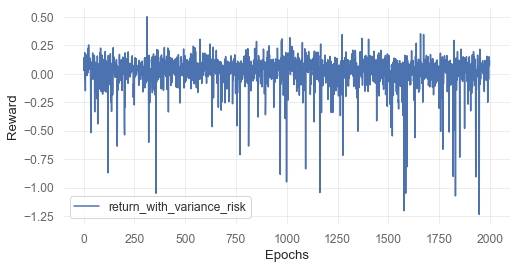

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:28<00:00, 47.98it/s]


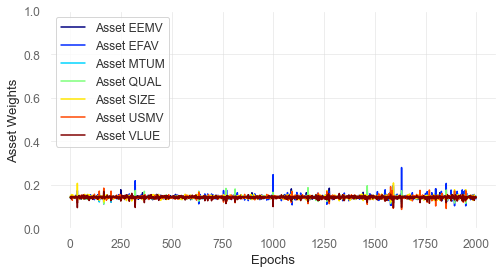


 23%|█████████████████▍                                                           | 2257/10000 [01:00<03:22, 38.27it/s]


 26%|███████████████████▋                                                         | 2559/10000 [01:08<03:20, 37.13it/s]


 28%|█████████████████████▉                                                       | 2844/10000 [01:16<03:25, 34.78it/s]


 31%|███████████████████████▉                                                     | 3111/10000 [01:24<03:22, 34.06it/s]


 34%|█████████████████████████▉                                                   | 3376/10000 [01:32<03:11, 34.59it/s]


 36%|████████████████████████████                                                 | 3642/10000 [01:40<03:24, 31.11it/s]


 39%|█████████████████████████████▊                                               | 3879/10000 [01:48<03:13, 31.62it/s]


 40%|██████████████████████████████▊                                              | 3997/10000 [01:52<03:10, 31.54it/s]

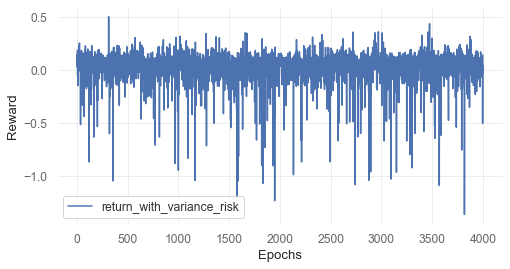

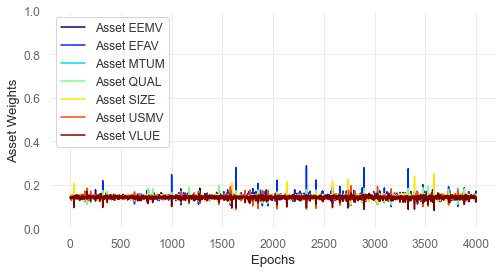


 43%|████████████████████████████████▊                                            | 4255/10000 [02:01<02:59, 31.98it/s]


 45%|██████████████████████████████████▊                                          | 4520/10000 [02:09<02:45, 33.15it/s]


 48%|████████████████████████████████████▊                                        | 4783/10000 [02:18<02:47, 31.07it/s]


 50%|██████████████████████████████████████▊                                      | 5044/10000 [02:26<02:36, 31.65it/s]


 53%|████████████████████████████████████████▊                                    | 5308/10000 [02:34<02:32, 30.69it/s]


 56%|██████████████████████████████████████████▊                                  | 5562/10000 [02:43<02:20, 31.48it/s]


 58%|████████████████████████████████████████████▊                                | 5826/10000 [02:51<02:19, 29.94it/s]


 60%|██████████████████████████████████████████████▏                              | 6000/10000 [02:59<03:23, 19.69it/s]

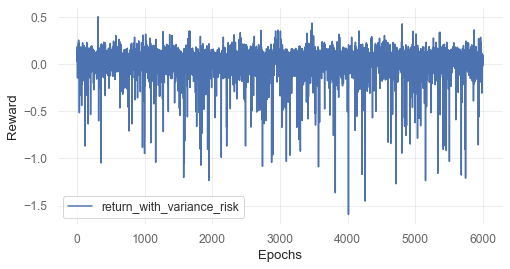

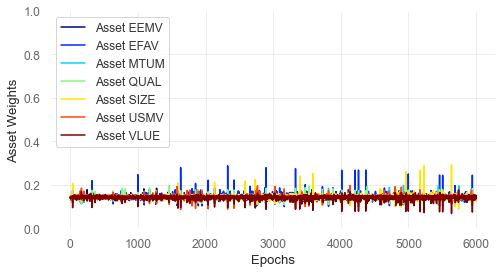


 62%|████████████████████████████████████████████████                             | 6246/10000 [03:09<02:08, 29.15it/s]


 65%|██████████████████████████████████████████████████                           | 6509/10000 [03:17<01:56, 29.88it/s]


 68%|████████████████████████████████████████████████████                         | 6769/10000 [03:25<01:56, 27.78it/s]


 70%|██████████████████████████████████████████████████████▏                      | 7033/10000 [03:34<01:43, 28.74it/s]


 73%|████████████████████████████████████████████████████████▏                    | 7297/10000 [03:42<01:24, 31.97it/s]


 75%|██████████████████████████████████████████████████████████                   | 7547/10000 [03:50<01:18, 31.40it/s]


 78%|████████████████████████████████████████████████████████████                 | 7800/10000 [03:59<01:09, 31.53it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 7998/10000 [04:06<01:25, 23.43it/s]

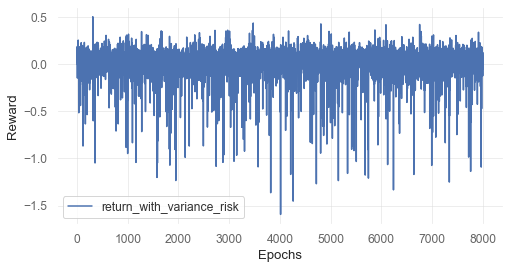

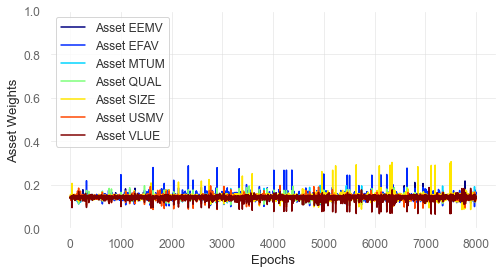


 82%|███████████████████████████████████████████████████████████████▎             | 8218/10000 [04:15<00:52, 33.70it/s]


 85%|█████████████████████████████████████████████████████████████████▏           | 8474/10000 [04:23<00:43, 34.80it/s]


 87%|███████████████████████████████████████████████████████████████████▎         | 8739/10000 [04:31<00:36, 34.60it/s]


 90%|█████████████████████████████████████████████████████████████████████        | 8974/10000 [04:40<00:26, 38.19it/s]


 92%|███████████████████████████████████████████████████████████████████████▏     | 9248/10000 [04:47<00:21, 35.77it/s]


 95%|█████████████████████████████████████████████████████████████████████████▎   | 9523/10000 [04:55<00:12, 37.89it/s]


 98%|███████████████████████████████████████████████████████████████████████████▍ | 9802/10000 [05:02<00:05, 34.58it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9998/10000 [05:08<00:00, 38.11it/s]

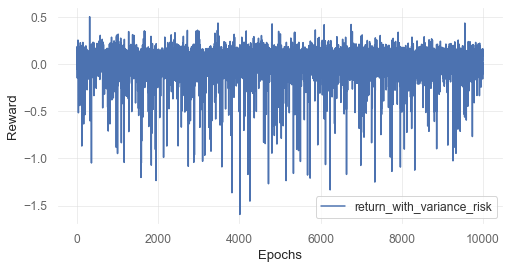

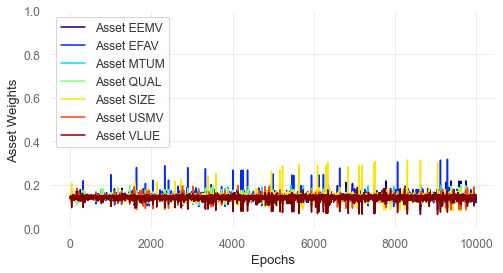

[]

In [16]:
# create environment and run REINFORCE with baseline
env_reinforce_baseline_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_reinforce_baseline_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_reinforce_baseline = LinearAgent(environment=env_reinforce_baseline_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_reinforce_baseline.REINFORCE_fit(max_iterations=max_iter, add_baseline=True, verbose=True)

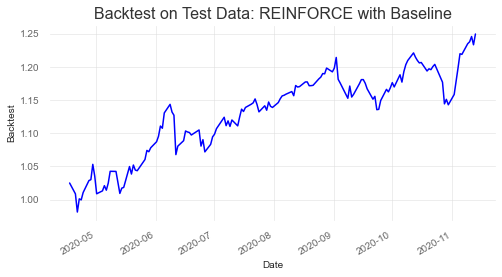

In [17]:
# perform backtest 
backtest_reinforce_baseline = plot_backtest(linear_agent_reinforce_baseline, env_reinforce_baseline_test, portfolio_df_test, model="REINFORCE with Baseline")
backtest_reinforce_baseline.to_csv('temp_persisted_data/'+model_run+'backtest_reinforce_baseline.csv')

### Actor-Critic

 20%|███████████████▍                                                             | 1999/10000 [00:57<05:55, 22.52it/s]

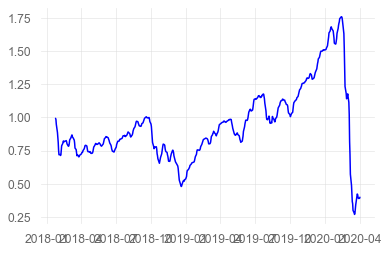

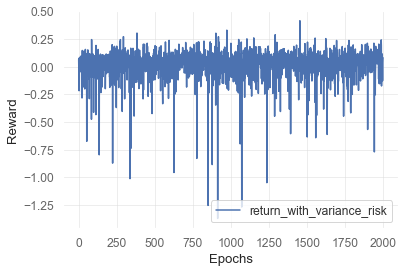

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:13<00:00, 26.75it/s]


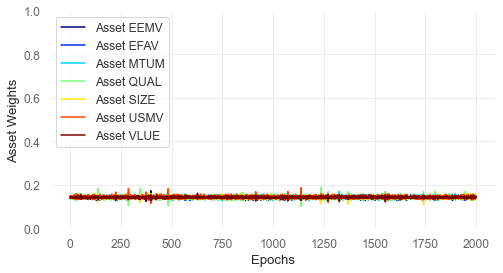

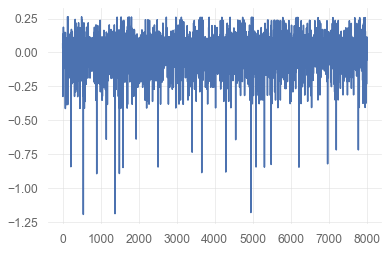

 40%|██████████████████████████████▊                                              | 3999/10000 [02:24<05:18, 18.85it/s]

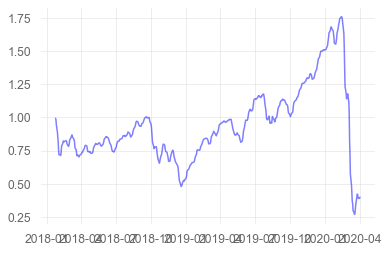

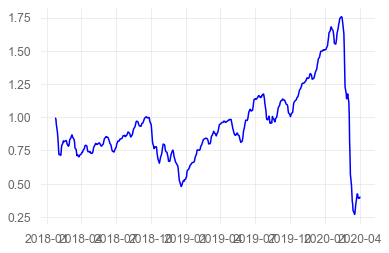

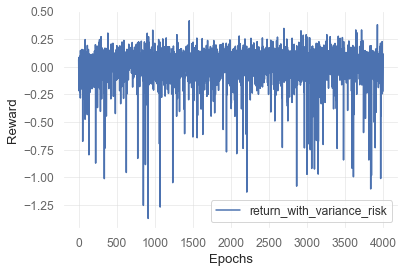

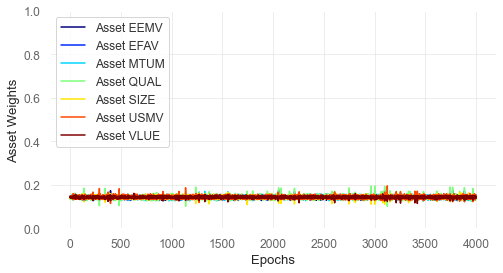

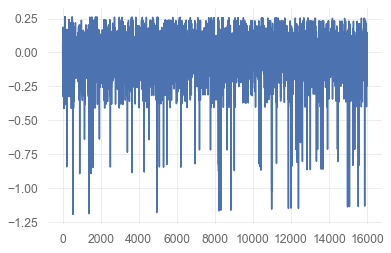

 60%|██████████████████████████████████████████████▏                              | 5999/10000 [03:31<02:11, 30.49it/s]

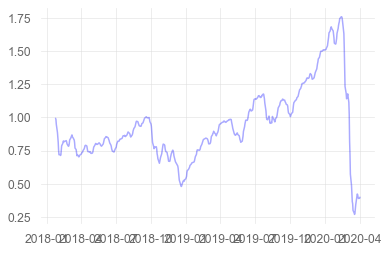

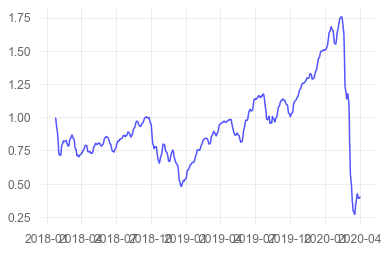

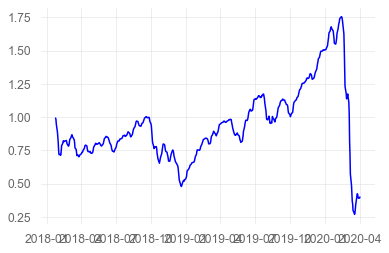

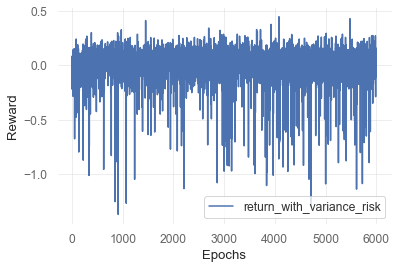

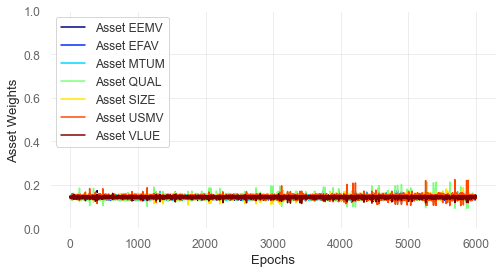

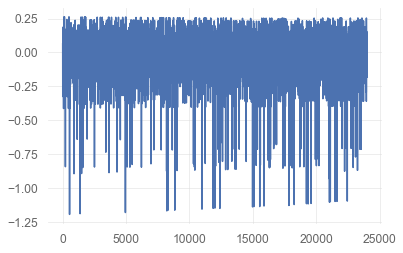

 80%|█████████████████████████████████████████████████████████████▌               | 7997/10000 [04:29<00:38, 52.07it/s]

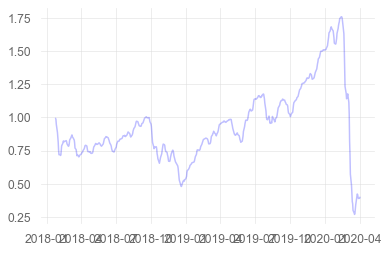

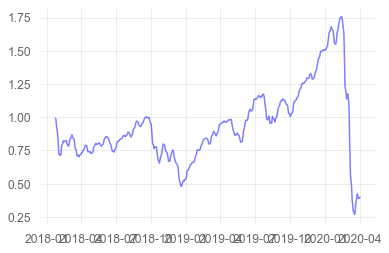

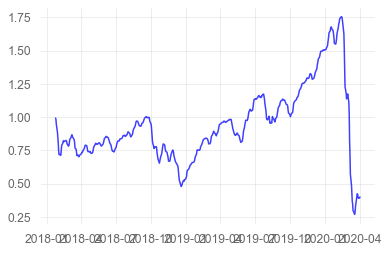

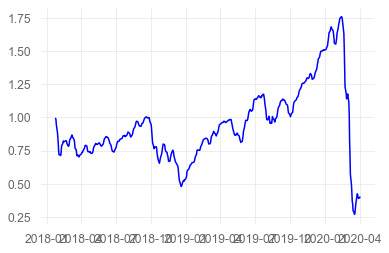

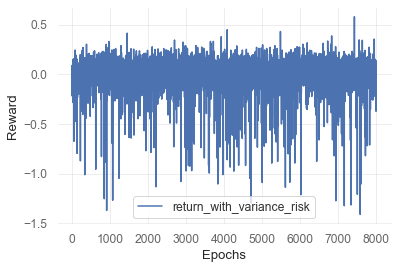

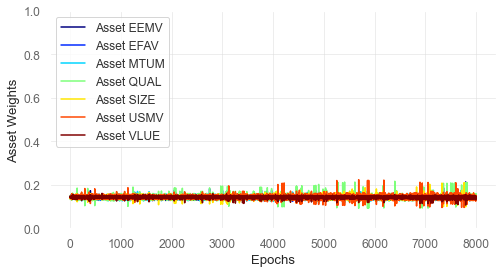

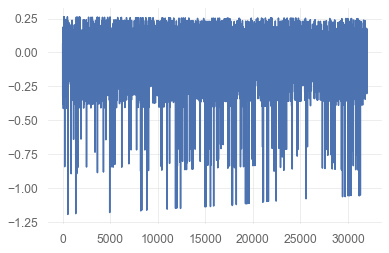

100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [05:24<00:00, 54.35it/s]

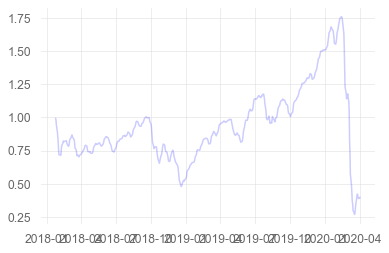

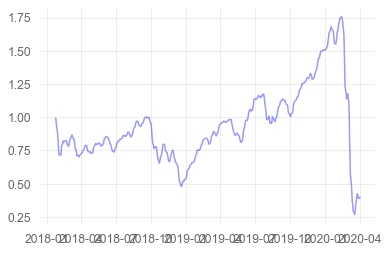

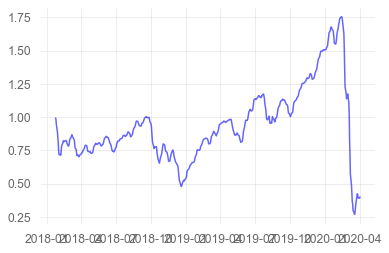

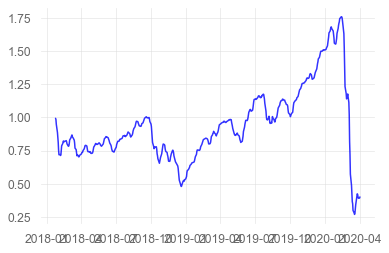

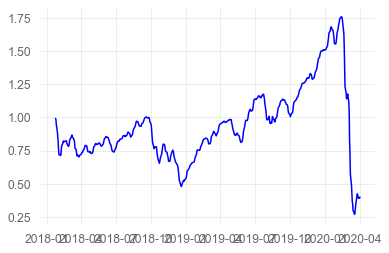

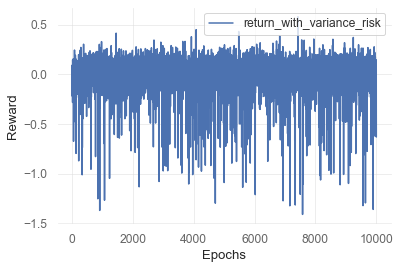

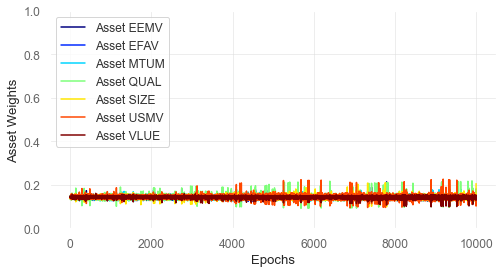

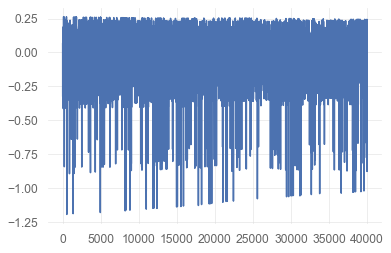

[]

In [18]:
# create environment and run Actor-Critic 

env_actor_critic_no_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_no_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_no_trace = LinearAgent(environment=env_actor_critic_no_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_no_trace.ACTOR_CRITIC_FIT(use_traces=False,max_iterations=max_iter, verbose=True)

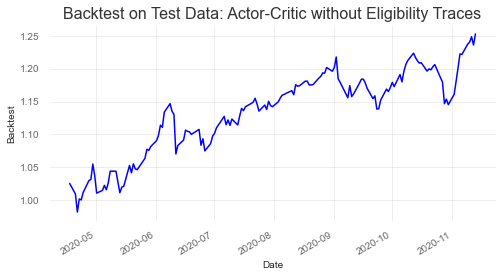

In [19]:
# perform backtest
backtest_actor_critic_no_trace = plot_backtest(linear_agent_actor_critic_no_trace, env_actor_critic_no_trace_test,  portfolio_df_test, model="Actor-Critic without Eligibility Traces")
backtest_actor_critic_no_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_no_trace.csv')

### Actor-Critic with Eligibility Traces


pre-sampling indices: 100%|█████████████████████████████████████████████████████████| 528/528 [00:01<00:00, 344.84it/s]

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:38<00:00, 54.35it/s]


  6%|████▎                                                                         | 556/10000 [00:13<03:21, 46.84it/s]


  9%|██████▉                                                                       | 882/10000 [00:21<03:18, 45.97it/s]


 12%|█████████▎                                                                   | 1215/10000 [00:28<03:20, 43.83it/s]


 15%|███████████▊                                                                 | 1528/10000 [00:36<06:01, 23.42it/s]


 18%|██████████████                                                               | 1819/10000 [00:44<04:13, 32.26it/s]


 20%|███████████████▍                                                             | 2000/10000 [00:48<02:52, 46.34it/s]

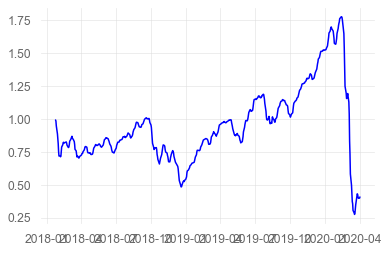

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:22<00:00, 26.15it/s]


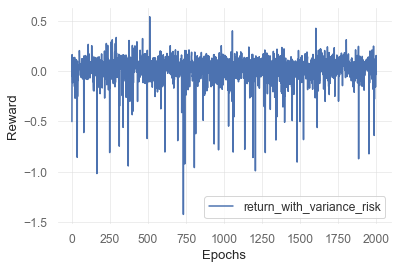

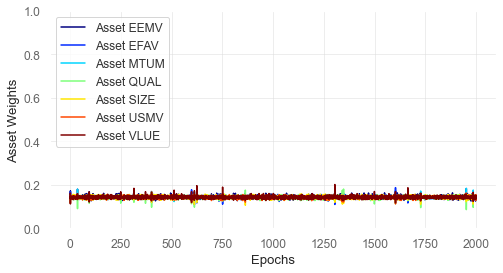

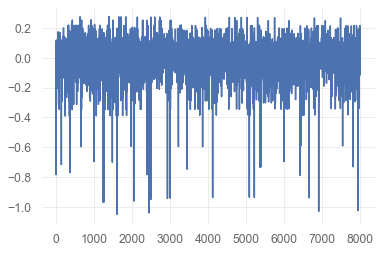


 23%|█████████████████▉                                                           | 2337/10000 [00:58<02:50, 45.07it/s]


 26%|███████████████████▊                                                         | 2577/10000 [01:07<03:16, 37.79it/s]


 28%|█████████████████████▍                                                       | 2788/10000 [01:15<05:12, 23.09it/s]


 31%|███████████████████████▌                                                     | 3063/10000 [01:24<02:32, 45.64it/s]


 34%|██████████████████████████                                                   | 3386/10000 [01:32<02:29, 44.12it/s]


 37%|████████████████████████████▋                                                | 3720/10000 [01:39<02:13, 46.89it/s]


 40%|██████████████████████████████▊                                              | 3997/10000 [01:46<02:18, 43.21it/s]

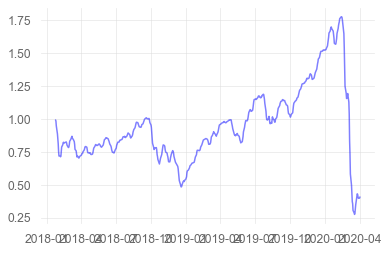

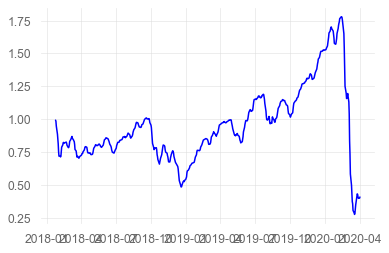

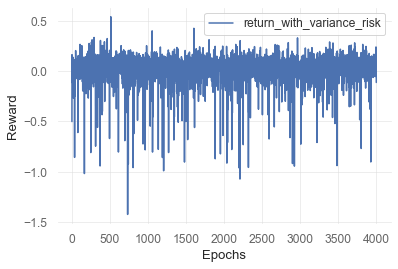

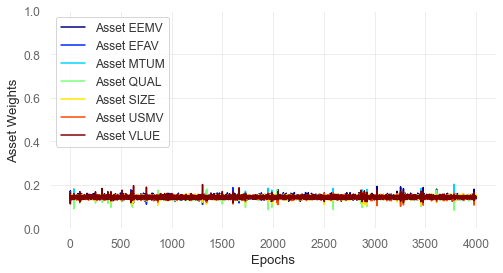

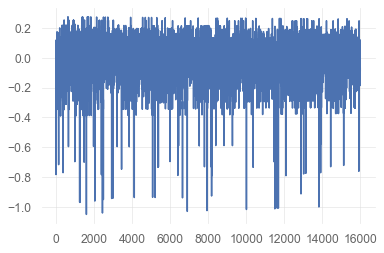


 43%|█████████████████████████████████▎                                           | 4328/10000 [01:56<02:06, 44.84it/s]


 47%|███████████████████████████████████▉                                         | 4660/10000 [02:04<02:08, 41.48it/s]


 50%|██████████████████████████████████████▏                                      | 4962/10000 [02:11<02:38, 31.87it/s]


 52%|████████████████████████████████████████▍                                    | 5249/10000 [02:20<02:00, 39.47it/s]


 56%|██████████████████████████████████████████▉                                  | 5582/10000 [02:27<01:50, 39.86it/s]


 59%|█████████████████████████████████████████████▎                               | 5889/10000 [02:35<01:55, 35.72it/s]


 60%|██████████████████████████████████████████████▏                              | 5997/10000 [02:38<01:36, 41.69it/s]

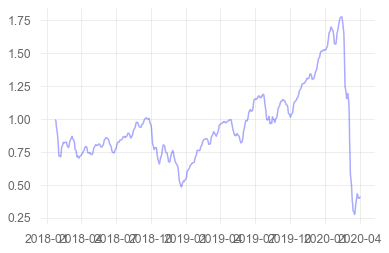

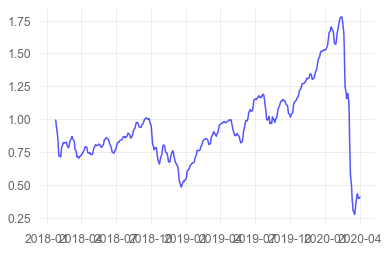

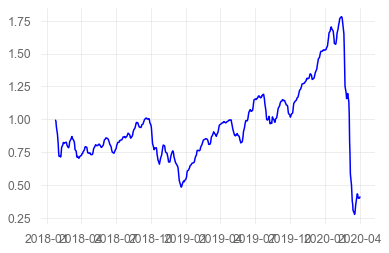

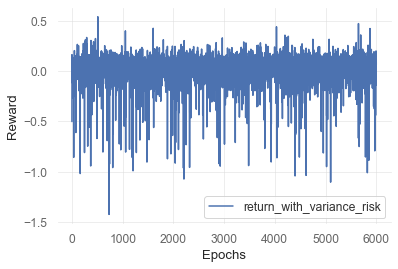

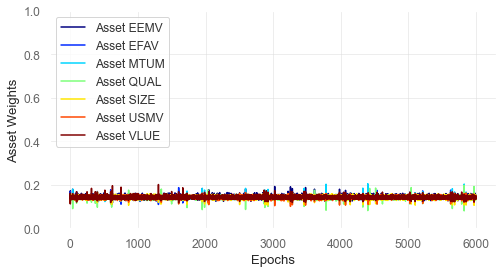

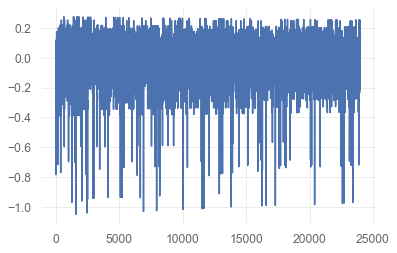


 63%|████████████████████████████████████████████████▋                            | 6329/10000 [02:47<01:26, 42.54it/s]


 67%|███████████████████████████████████████████████████▏                         | 6654/10000 [02:55<01:17, 43.43it/s]


 70%|█████████████████████████████████████████████████████▋                       | 6973/10000 [03:03<01:12, 41.96it/s]


 72%|███████████████████████████████████████████████████████▊                     | 7241/10000 [03:12<01:44, 26.41it/s]


 75%|█████████████████████████████████████████████████████████▉                   | 7518/10000 [03:20<00:53, 46.65it/s]


 78%|████████████████████████████████████████████████████████████▎                | 7834/10000 [03:28<01:03, 34.08it/s]


 80%|█████████████████████████████████████████████████████████████▌               | 7998/10000 [03:32<00:41, 48.17it/s]

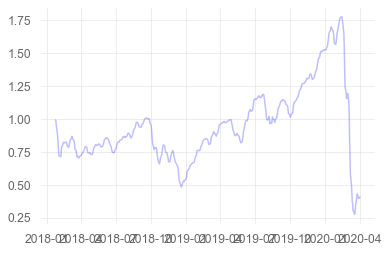

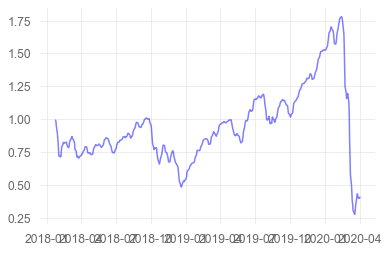

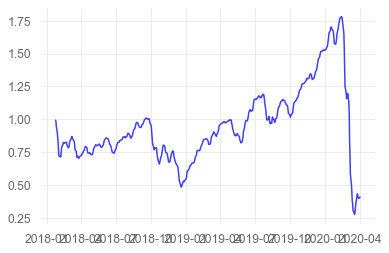

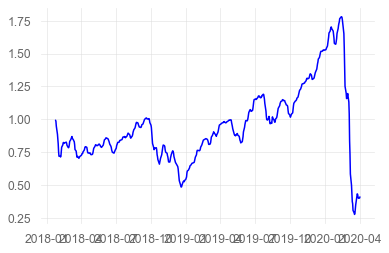

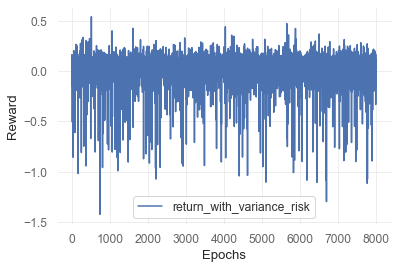

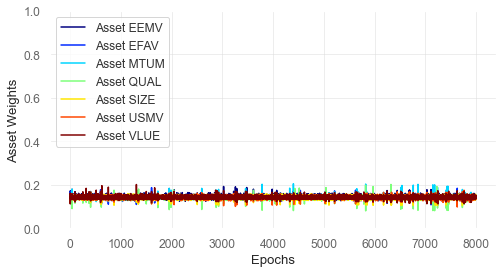

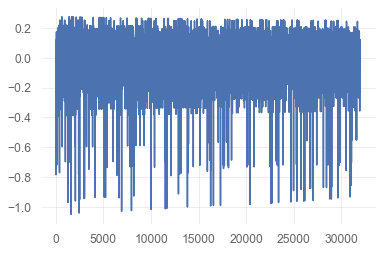


 84%|████████████████████████████████████████████████████████████████▎            | 8353/10000 [03:43<00:34, 47.14it/s]


 87%|███████████████████████████████████████████████████████████████████▏         | 8732/10000 [03:50<00:23, 53.04it/s]


 91%|█████████████████████████████████████████████████████████████████████▊       | 9069/10000 [03:58<00:28, 32.93it/s]


 94%|████████████████████████████████████████████████████████████████████████▎    | 9387/10000 [04:06<00:13, 43.80it/s]


 97%|██████████████████████████████████████████████████████████████████████████▊  | 9722/10000 [04:14<00:06, 41.48it/s]


100%|████████████████████████████████████████████████████████████████████████████▉| 9996/10000 [04:20<00:00, 37.25it/s]

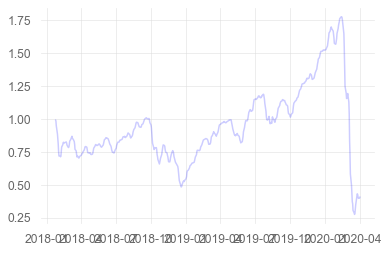

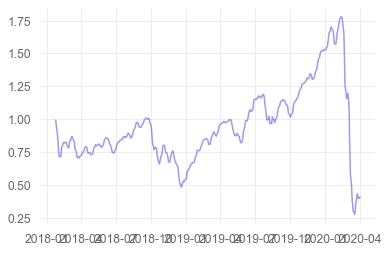

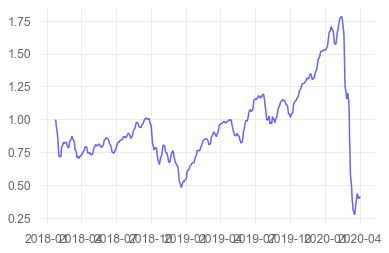

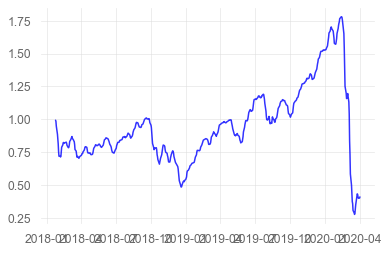

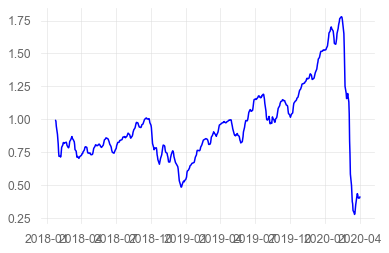

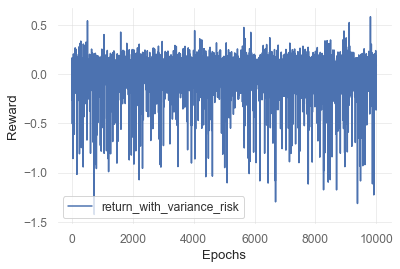

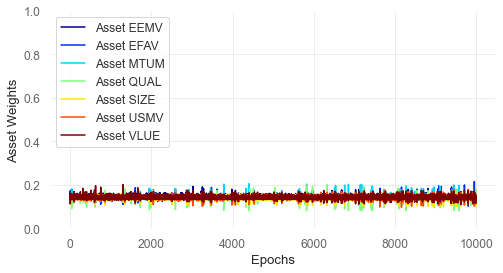

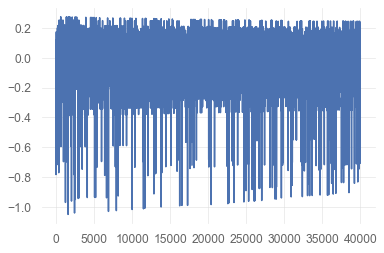

[]

In [20]:
# create environment and run Actor-Critic with Eligibility Traces 
env_actor_critic_trace_train = DeepTradingEnvironment(features_train, forward_returns_train, forward_return_dates_train, objective_parameters,
                 meta_parameters)
env_actor_critic_trace_test = DeepTradingEnvironment(features_test, forward_returns_test, forward_return_dates_test, objective_parameters,
                 meta_parameters)

linear_agent_actor_critic_trace = LinearAgent(environment=env_actor_critic_trace_train,out_reward_window_td=out_reward_window, reward_function="return_with_variance_risk",sample_observations=sample_observations)
linear_agent_actor_critic_trace.ACTOR_CRITIC_FIT(use_traces=True,max_iterations=max_iter, verbose=True)

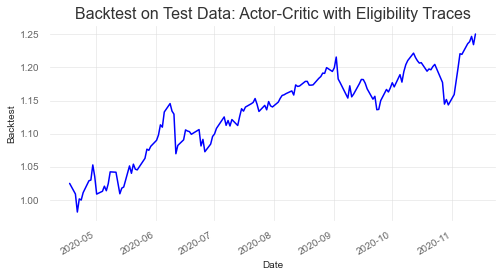


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:35<00:00, 37.25it/s]

In [21]:
# perform backtest 
backtest_actor_critic_trace = plot_backtest(linear_agent_actor_critic_trace, env_actor_critic_trace_test,  portfolio_df_test, model="Actor-Critic with Eligibility Traces")
backtest_actor_critic_trace.to_csv('temp_persisted_data/'+model_run+'backtest_actor_critic_trace.csv')